## Identifying a Dataset

In [ ]:
"""
Downloading a dataset that contains weekly data for the Dow Jones Industrial Index.
Citation:
Brown,Michael. (2014). Dow Jones Index. UCI Machine Learning Repository. https://doi.org/10.24432/C5788V.
@misc{misc_dow_jones_index_312,
  author       = {Brown,Michael},
  title        = {{Dow Jones Index}},
  year         = {2014},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C5788V}
}
"""

## Identifying the Topic and Goal

**Project Topic:** Exploring weekly data from the Dow Jones to establish relationships between changes in stock prices and other inputs.

**Project Goal:** The goal of the project is to find the best of a selected set of supervised learning methods to predict the percentage change in a stock's price from one week to the next.

**Data (Source and Description):** Weekly data from the Dow Jones Industrial Index. 

Citation:

Brown,Michael. (2014). Dow Jones Index. UCI Machine Learning Repository. https://doi.org/10.24432/C5788V.

@misc{misc_dow_jones_index_312,

  author       = {Brown,Michael},
  
  title        = {{Dow Jones Index}},
  
  year         = {2014},
  
  howpublished = {UCI Machine Learning Repository},
  
  note         = {{DOI}: https://doi.org/10.24432/C5788V}
  
}

The data was downloaded here: https://archive.ics.uci.edu/dataset/312/dow+jones+index

This dataset has $750$ observations and $16$ features.

This response variable was explicitly identified by the authors/contributors of the dataset as:
*percent_change_next_weeks_price*.

## Cleaning and EDA

In [ ]:
#Checking the location of the local directory for my Jupyter notebook to download data in the proper place
import os
os.getcwd()

In [3]:
#Importing necessary packages
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

In [4]:
file_path = "~\\dow_jones_index.data"
#Based on a quick visual inspection through notepad, this file appears to be comma-delimited
dji_data = pd.read_csv(file_path, delimiter = ",")

**Data Cleaning**

***Inspecting the Data***

In [5]:
#Checking out the top few rows of data to see how everything loaded
dji_data.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [6]:
dji_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [9]:
print('Earliest financial quarter:', dji_data.quarter.min(), ', and latest quarter:', dji_data.quarter.max())

Earliest financial quarter: 1 , and latest quarter: 2


In [10]:
#Checking the number of observations in each quarter to ensure I'll have a balance for training and testing
print(dji_data.groupby('quarter')['stock'].count())

quarter
1    360
2    390
Name: stock, dtype: int64


### Priorities for Initial Cleaning and Organization

This dataset has $750$ observations and $16$ variables. The response variable for this model
(what we want to test) is *percent_change_next_weeks_price*; that leaves $15$ observations.
As seasons might play a role, I'm going to follow a procedure I've seen followed elsewhere in financial/economic returns
and treat the quarters as distinct training/testing units. I'll use quarter $1$ for training and quarter $2$ for testing.

Note: I'm uncomfortable with having a balance in favor of testing. The reason I'm pursuing this split anyway is because I would assume financial trends to flow forward, i.e., the effect of variables should establish themselves in time and either strengthen or diminish accordingly. It doesn't make intuitive sense to me to use the quarter with the higher number of observations (quarter $2$) to train the model and then test the model on an earlier time period.

Using the quarters to differentiate training vs. testing sets leaves us with $14$ additional dependent variables about which to make decisions. I'll work through those now.

*Data type* ***munging*** is necessary for 'stock', 'date', and the financial columns. I'll perform that now.

In [11]:
#Changing the data types.
#'stock' should be a factor.
#'date' should be a datetype.
#'open', 'high', 'low', 'close', 'next_weeks_open', and 'next_weeks_close' should be numeric.

dji_data['stock'] = dji_data['stock'].astype('category')
dji_data['date'] = pd.to_datetime(dji_data['date'])

#Need to remove the '$' to convert the columns with currency values to numeric
dji_data[dji_data.columns[3:7]] = dji_data[dji_data.columns[3:7]].replace('[\$,]', '', regex = True).astype(float)
dji_data[dji_data.columns[11:13]] = dji_data[dji_data.columns[11:13]].replace('[\$,]', '', regex = True).astype(float)

dji_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    int64         
 1   stock                               750 non-null    category      
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    float64       
 4   high                                750 non-null    float64       
 5   low                                 750 non-null    float64       
 6   close                               750 non-null    float64       
 7   volume                              750 non-null    int64         
 8   percent_change_price                750 non-null    float64       
 9   percent_change_volume_over_last_wk  720 non-null    float64       
 10  previous_weeks_volume     

In [12]:
#Investigating the data frame further to determine spot missing values and other analytical challenges
dji_data.describe()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
count,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,720.000000,7.200000e+02,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.520000,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,5.593627,1.173876e+08,53.702440,53.889080,0.238468,52.525333,0.691826
std,0.499933,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,40.543478,1.592322e+08,32.778111,33.016677,2.679538,46.335098,0.305482
min,1.000000,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,10.520000,10.520000,-15.422900,0.000000,0.065574
25%,1.000000,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-19.804284,3.067832e+07,30.315000,30.462500,-1.222067,24.000000,0.534549
50%,2.000000,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,0.512586,5.294556e+07,46.015000,46.125000,0.101193,47.000000,0.681067
75%,2.000000,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,21.800622,1.333230e+08,72.715000,72.915000,1.845562,69.000000,0.854291
max,2.000000,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,327.408924,1.453439e+09,172.110000,174.540000,9.882230,336.000000,1.564210


In [13]:
#No obvious issues turned up using the summary statistics above; checking through for any missing/NA values to be sure
dji_data.isnull().any()

quarter                               False
stock                                 False
date                                  False
open                                  False
high                                  False
low                                   False
close                                 False
volume                                False
percent_change_price                  False
percent_change_volume_over_last_wk     True
previous_weeks_volume                  True
next_weeks_open                       False
next_weeks_close                      False
percent_change_next_weeks_price       False
days_to_next_dividend                 False
percent_return_next_dividend          False
dtype: bool

In [14]:
#2 columns have NAs, so I'm going to look at them to decide what to do with them
dji_data.isna()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
746,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
747,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
748,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
same_obs = sum((dji_data[dji_data['percent_change_volume_over_last_wk'].isna()].index != 
     dji_data[dji_data['previous_weeks_volume'].isna()].index))
if same_obs == 0:
    obs_with_NA = dji_data[dji_data['percent_change_volume_over_last_wk'].isna()].index.to_list()
    print('The same observations have NAs in both columns:', '\n',obs_with_NA)

The same observations have NAs in both columns: 
 [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300, 312, 324, 336, 348]


How to treat these? As recent trends are widely believed to be reflected in asset values, I don't think they can be ignored.
Neither do I think they should be imputed as I don't have a solid methodological/theoretical basis to 'assume'
any particular values.
I'm going to eliminate these values from the training data so as not to soften the value of recent volume.
These values are clearly dependent on one another, so it makes sense to remove both.

In [16]:
#Removing NA observations
dji_data.drop(obs_with_NA, axis = 0, inplace = True)

In [17]:
dji_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 1 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             720 non-null    int64         
 1   stock                               720 non-null    category      
 2   date                                720 non-null    datetime64[ns]
 3   open                                720 non-null    float64       
 4   high                                720 non-null    float64       
 5   low                                 720 non-null    float64       
 6   close                               720 non-null    float64       
 7   volume                              720 non-null    int64         
 8   percent_change_price                720 non-null    float64       
 9   percent_change_volume_over_last_wk  720 non-null    float64       
 10  previous_weeks_volume     

### Exploratory Data Analysis: Visualizations

Time series data have intriguing issues related to correlation. I'm going to look for some of the most correlated variables.

In [18]:
#Looking at correlated variables and potential collinearity:
dji_data.corr()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
quarter,1.000000,0.023726,0.022625,0.022775,0.019811,-0.037889,-0.076259,0.023662,-0.057302,0.018354,0.017176,0.000098,-0.020749,-0.007963
open,0.023726,1.000000,0.999613,0.999339,0.999049,-0.522450,0.074321,-0.008510,-0.511910,0.998950,0.997774,0.066695,-0.059737,-0.147291
high,0.022625,0.999613,1.000000,0.999420,0.999555,-0.521307,0.091083,-0.006513,-0.511344,0.999476,0.998481,0.069589,-0.060586,-0.149462
low,0.022775,0.999339,0.999420,1.000000,0.999549,-0.524210,0.095997,-0.017541,-0.511540,0.999435,0.998299,0.067255,-0.060948,-0.144788
close,0.019811,0.999049,0.999555,0.999549,1.000000,-0.523935,0.110531,-0.016479,-0.511354,0.999917,0.998836,0.067789,-0.060981,-0.147205
volume,-0.037889,-0.522450,-0.521307,-0.524210,-0.523935,1.000000,-0.173245,0.181672,0.887631,-0.523710,-0.523208,-0.091106,-0.057734,-0.269797
percent_change_price,-0.076259,0.074321,0.091083,0.095997,0.110531,-0.173245,1.000000,-0.234496,-0.068675,0.110819,0.111796,0.020639,-0.009060,0.049963
percent_change_volume_over_last_wk,0.023662,-0.008510,-0.006513,-0.017541,-0.016479,0.181672,-0.234496,1.000000,-0.129519,-0.015416,-0.015660,0.013181,-0.033348,-0.017486
previous_weeks_volume,-0.057302,-0.511910,-0.511344,-0.511540,-0.511354,0.887631,-0.068675,-0.129519,1.000000,-0.511349,-0.511120,-0.102408,-0.047727,-0.270266
next_weeks_open,0.018354,0.998950,0.999476,0.999435,0.999917,-0.523710,0.110819,-0.015416,-0.511349,1.000000,0.998872,0.067147,-0.061205,-0.147101


***Supplementary visualizations***

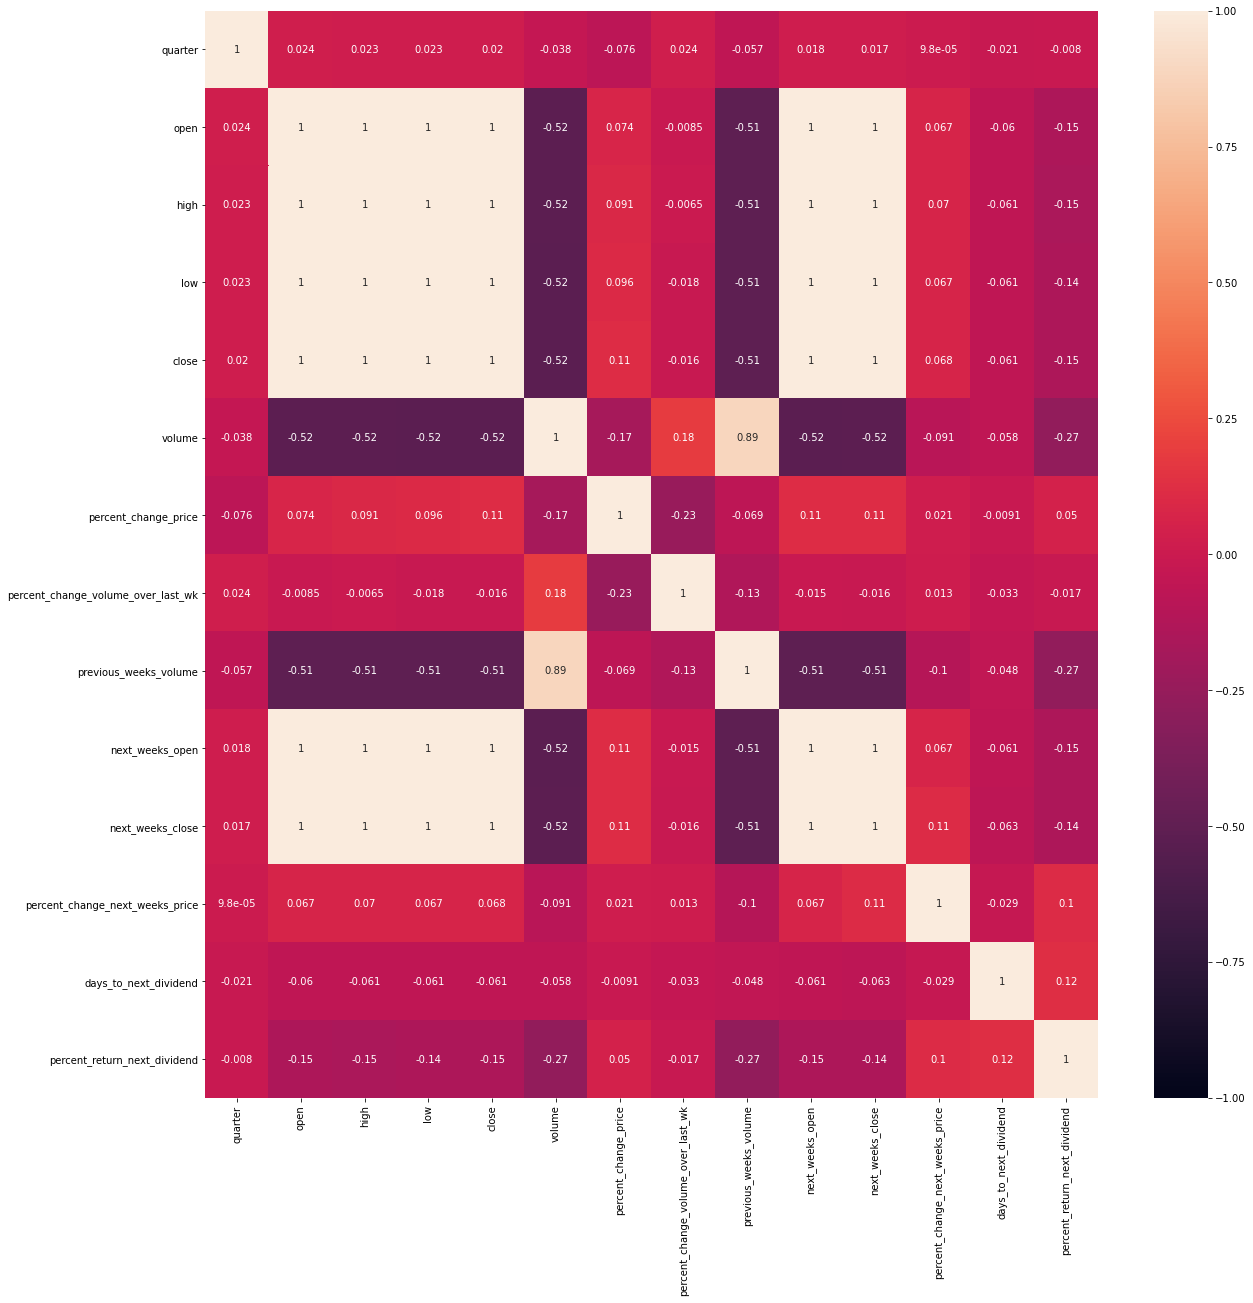

In [19]:
#To make this a bit clearer, I'm going to use a heatmap:
plt.subplots(figsize=(20,20))
sns.heatmap(dji_data.corr(), vmin = -1, vmax = 1, annot=True)

So that helped a bit; a number of variables are completely correlated, probably dependent, and can likely be omitted.
Looking at the heatmap as a guide, and after examining what each variable stands for, many variables can be eliminated;
for example, most high-low values expressed elsewhere as '% change', and 'open' and 'close' are often the same (though
separated by a trading cycle.)

Keeping the following variables: *'quarter', 'stock', 'date', 'open', 'percent_change_price', 'percent_change_volume_over_last_wk',
'days_to_next_dividend',* and *'percent_return_next_dividend'*.

In [20]:
dji_red = (dji_data.drop(['high', 'low', 'close', 'volume', 'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close'],
                        axis = 1))

In [21]:
#Looking at the correlations (or lack thereof) between the remaining variables is encouraging:
dji_red.corr()

,quarter,open,percent_change_price,percent_change_volume_over_last_wk,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
quarter,1.000000,0.023726,-0.076259,0.023662,0.000098,-0.020749,-0.007963
open,0.023726,1.000000,0.074321,-0.008510,0.066695,-0.059737,-0.147291
percent_change_price,-0.076259,0.074321,1.000000,-0.234496,0.020639,-0.009060,0.049963
percent_change_volume_over_last_wk,0.023662,-0.008510,-0.234496,1.000000,0.013181,-0.033348,-0.017486
percent_change_next_weeks_price,0.000098,0.066695,0.020639,0.013181,1.000000,-0.028797,0.103009
days_to_next_dividend,-0.020749,-0.059737,-0.009060,-0.033348,-0.028797,1.000000,0.119733
percent_return_next_dividend,-0.007963,-0.147291,0.049963,-0.017486,0.103009,0.119733,1.000000


In [22]:
#Now to create the training and testing sets:
df_train = dji_red[dji_red['quarter'] == 1]
df_test = dji_red[dji_red['quarter'] == 2]

## Models

### Model 1: MLR with forward-stepwise refinement

Now that the data is ready for analysis, I'll try to find the best method for modeling the changes in a stock's price from one week to the next. These methods are going to target regression as an outcome; as such, it makes sense to start with some simpler supervised-learning regression methods and build upon that effectiveness. I'll begin with *multiple linear regression with forward-stepwise refinement*.  

In [23]:
#Listing the variables to test:
var_lst = ['date', 'stock', 'open', 'percent_change_price', 'percent_change_volume_over_last_wk', 'days_to_next_dividend',
           'percent_return_next_dividend']

Using $R^2$ as a performance metric, checking to see which of the remaining predictor variables could be used for the model.

In [24]:
top_pred = ['',0]
for pred in var_lst:
    mod  = smf.ols(formula='percent_change_next_weeks_price~' + pred, data=df_train).fit()
    print(pred, mod.rsquared)
    if mod.rsquared>top_pred[1]:
        top_pred = [pred, mod.rsquared]
print('top predictor:',top_pred)

date 0.20668531066314666
stock 0.09601681473188539
open 0.014953787257643847
percent_change_price 0.00010762721805457343
percent_change_volume_over_last_wk 0.0019855441687202102
days_to_next_dividend 2.7830735561673592e-05
percent_return_next_dividend 0.012004612274825632
top predictor: ['date', 0.20668531066314666]


**Analysis of Model 1:**

None of those did well; the $R^2$ of $0.207$ for 'date' and $0.096$ for 'stock' are low. Furthermore, it only shows that the top-performing predictor variables are the dates and the stock itself; in the case of the stock, this means we can ditch most of these other predictors and focus on a company's fundamentals/financials/performance as well as the timing. And maybe that's true. But rather than continue down this path, I'd like to test some alternative models; I'll move on from MLR for now.

### Model 2: Random-Forest Regression

While random forest models can be used for classification problems, they can also be used for regression. As they are reputed for their effectiveness in modeling noisy, multi-featured data, it makes sense to try random-forest regression for this modeling problem.

I'll facilitate this with an **additional layer of data munging** by transforming the date to a categorical variable; quarter and stock can be dropped as well for this problem. I'll define X and y as the set of predictor variables and the response variable, respectively.

In [25]:
df_train['date'] = df_train['date'].astype('category')

X = df_train.drop(['quarter', 'stock', 'percent_change_next_weeks_price'], axis = 1)
y = df_train['percent_change_next_weeks_price']

<ipython-input-25-b742c9ec5a95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = df_train['date'].astype('category')


In [26]:
#Exploring X to make sure the data types are usable for random-forest regression:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 1 to 359
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   date                                330 non-null    category
 1   open                                330 non-null    float64 
 2   percent_change_price                330 non-null    float64 
 3   percent_change_volume_over_last_wk  330 non-null    float64 
 4   days_to_next_dividend               330 non-null    int64   
 5   percent_return_next_dividend        330 non-null    float64 
dtypes: category(1), float64(4), int64(1)
memory usage: 16.2 KB


In [27]:
#Let's see how many estimators will be needed to improve the fit on the training data.
#Using root mean squared error (RMSE) to evaluate the random forest predictions
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
rmse_vals = []
for i in range(1, 41, 1):
    reg = RandomForestRegressor(n_estimators = i, random_state = 42)
    reg.fit(X, y)
    ytrain_pred = reg.predict(X)
    rmse_met = mean_squared_error(ytrain_pred, y, squared = False)
    rmse_vals.append(rmse_met)

Text(0, 0.5, 'RMSE')

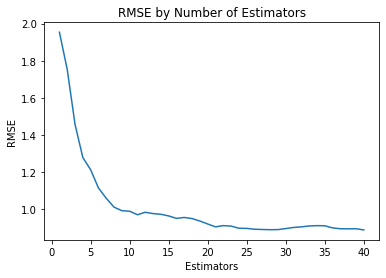

In [28]:
plt.plot(range(1, 41, 1), rmse_vals)
plt.title('RMSE by Number of Estimators')
plt.xlabel('Estimators')
plt.ylabel('RMSE')

In [29]:
#Probably best around k = 21, as it is less complicated than higher values of k, while improvement slows down after that
reg_final = RandomForestRegressor(n_estimators = 21, random_state = 42)
reg_final.fit(X, y)
ytrain_pred = reg.predict(X)
mean_squared_error(ytrain_pred, y, squared = False)

0.8898449039209729

Text(0, 0.5, 'Actual Training')

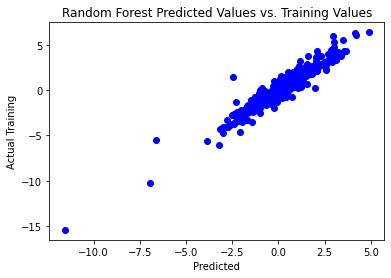

In [30]:
#And to have some sense of what those errors would look like, 
#I'm plotting the values here of the predicted values and the actual training values:
plt.plot(ytrain_pred, y, 'bo')
plt.title('Random Forest Predicted Values vs. Training Values')
plt.xlabel('Predicted')
plt.ylabel('Actual Training')

In [31]:
#Now let's see how it performs on the test data:
df_test['date'] = df_test['date'].astype('category')
X_test = df_test.drop(['quarter', 'stock', 'percent_change_next_weeks_price'], axis = 1)
y_test = df_test['percent_change_next_weeks_price']

ytest_pred = reg_final.predict(X_test)
rmse_test = mean_squared_error(ytest_pred, y_test, squared = False)
rmse_test

<ipython-input-31-7df5e8ffcfb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['date'] = df_test['date'].astype('category')


3.1994612410358036

Text(0, 0.5, 'Actual Test')

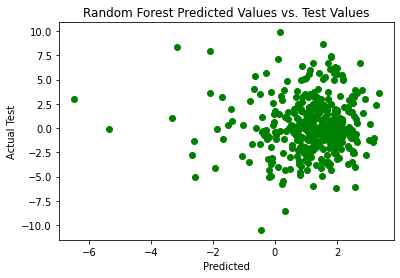

In [32]:
plt.plot(ytest_pred, y_test, 'go')
plt.title('Random Forest Predicted Values vs. Test Values')
plt.xlabel('Predicted')
plt.ylabel('Actual Test')

**Analysis of Model 2:**

Random-forest regression didn't perform as well as I'd hoped. It fit the training data considerably better than the testing data, which suggests the influence of other variables—perhaps uncaptured—which influenced the movement in stock prices.

What about pivoting on the problem by re-considering the *essence* of our goal? If the idea of predicting stock returns is to guide investment decisions, then couldn't a binary yes/no response to the question of *whether* to buy a stock be useful? In other words, if the effectiveness of regression modeling methods is doubtful here, then what about reframing the problem as a *classification* problem?

This implies the target of predicting whether a stock will move up or down. As most investors buy baskets of stocks rather than particular ones, perhaps understanding which to include in a purchase would make better sense and enable the reduction/dispersion of risk. So one way to look at this is as a problem where we're trying to predict whether the return will be positive or negative; I can create another variable to enable this analysis.

In [33]:
df_train['next_weeks_direction'] = (df_train['percent_change_next_weeks_price'] > 0).astype('int')
df_test['next_weeks_direction'] = (df_test['percent_change_next_weeks_price'] > 0).astype('int')

<ipython-input-33-29b8e74c82d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['next_weeks_direction'] = (df_train['percent_change_next_weeks_price'] > 0).astype('int')
<ipython-input-33-29b8e74c82d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['next_weeks_direction'] = (df_test['percent_change_next_weeks_price'] > 0).astype('int')


In [34]:
df_test['next_weeks_direction']

360    1
361    0
362    1
363    1
364    0
      ..
745    0
746    0
747    0
748    0
749    1
Name: next_weeks_direction, Length: 390, dtype: int32

## Model 3: Logistic Regression for Binary Classification

Logistic regression can be used to model binary responses (e.g., positive/negative price changes) using multiple predictor variables. To handle issues of dependence and collinearity, I'll drop the variable upon which the direction of the price change is based: *'percent_change_next_weeks_price'*.

In [35]:
#Trying binary classification via logistic regression to model the outcome: positive or negative price changes.
#Because 'percent_change_next_weeks_price' defines 'next_weeks_direction' it is necessary to drop that variable
X1 = df_train.drop(['quarter', 'stock', 'percent_change_next_weeks_price'], axis = 1)
y1 = df_train['next_weeks_direction']

log_reg = LogisticRegression(solver = 'liblinear').fit(X1, y1)

In [36]:
log_reg.coef_

array([[1.21608174e-19, 1.49117405e-35, 3.21205083e-37, 5.05217605e-36,
        2.81206834e-36, 1.22514030e-37, 1.23397357e-36]])

In [37]:
logreg_pred = log_reg.predict(X1)

In [38]:
#Checking to see how well this model did with the training data
print('accuracy is:', accuracy_score(y1, logreg_pred))
print('recall is:', recall_score(y1, logreg_pred))
print('precision is:', precision_score(y1, logreg_pred))

accuracy is: 0.5393939393939394
recall is: 1.0
precision is: 0.5393939393939394


In [39]:
#Now applying to the test data:
X1_test = df_test.drop(['quarter', 'stock', 'percent_change_next_weeks_price'], axis = 1)
X1_test['date'] = X1_test['date'].astype('category')
y1_test = df_test['next_weeks_direction']

logreg_test_pred = log_reg.predict(X1_test)
print('accuracy is:', accuracy_score(y1_test, logreg_test_pred))
print('recall is:', recall_score(y1_test, logreg_test_pred))
print('precision is:', precision_score(y1_test, logreg_test_pred))

accuracy is: 0.4717948717948718
recall is: 1.0
precision is: 0.4717948717948718


**Analysis of Model 3:**

The above was not much better. But what if the quarter is an important part of the data?
Trying these 3 methods after re-training the data to allow the quarters to be a variable; and increasing the size
of the training set.

In [40]:
df_train, df_test = train_test_split(dji_red, test_size = 0.2, random_state = 42)

### Model 1, Refined Approach

In [41]:
#MLR with forward-stepwise refinement:
var_lst = ['quarter', 'date', 'stock', 'open', 'percent_change_price', 'percent_change_volume_over_last_wk', 'days_to_next_dividend',
           'percent_return_next_dividend']

#Examining R^2:
top_pred = ['',0]
for pred in var_lst:
    mod  = smf.ols(formula='percent_change_next_weeks_price~' + pred, data=df_train).fit()
    print(pred, mod.rsquared)
    if mod.rsquared>top_pred[1]:
        top_pred = [pred, mod.rsquared]
print('top predictor:',top_pred)

quarter 0.0001591879125151241
date 0.39746662310429526
stock 0.0356942570582075
open 0.007622007688205645
percent_change_price 0.0008135912343921747
percent_change_volume_over_last_wk 6.400561953445738e-06
days_to_next_dividend 0.003943368295411309
percent_return_next_dividend 0.002569124016218116
top predictor: ['date', 0.39746662310429526]


**Analysis of Model 1, Refined Approach:**

That's a little better, although other than 'date' there still aren't any convincing predictors.

## Model 2, Refined Approach: Random-Forest Regression with a Larger Training Set

In [42]:
df_train['date'] = df_train['date'].astype('category')
X = df_train.drop(['stock', 'percent_change_next_weeks_price'], axis = 1)
y = df_train['percent_change_next_weeks_price']

<ipython-input-42-a25b7155b1c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = df_train['date'].astype('category')


Text(0, 0.5, 'RMSE')

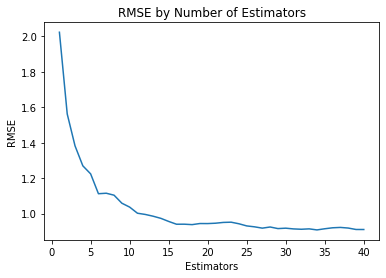

In [43]:
rmse_vals = []
for i in range(1, 41, 1):
    reg = RandomForestRegressor(n_estimators = i, random_state = 42)
    reg.fit(X, y)
    ytrain_pred = reg.predict(X)
    rmse_met = mean_squared_error(ytrain_pred, y, squared = False)
    rmse_vals.append(rmse_met)

plt.plot(range(1, 41, 1), rmse_vals)
plt.title('RMSE by Number of Estimators')
plt.xlabel('Estimators')
plt.ylabel('RMSE')

In [44]:
min(rmse_vals)

0.9081410194646273

**Analysis of Model 2, Refined Approach:**

Still not much better; no real need to test it as the goal was to find an improvement, which didn't happen with the training data.

### Model 2, Classification Approach

Random forests can also be used for classification; perhaps with the classification version of this problem, a random forest model might yield benefits?

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
df_train['next_weeks_direction'] = (df_train['percent_change_next_weeks_price'] > 0).astype('int')
df_test['next_weeks_direction'] = (df_test['percent_change_next_weeks_price'] > 0).astype('int')

<ipython-input-47-29b8e74c82d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['next_weeks_direction'] = (df_train['percent_change_next_weeks_price'] > 0).astype('int')
<ipython-input-47-29b8e74c82d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['next_weeks_direction'] = (df_test['percent_change_next_weeks_price'] > 0).astype('int')


In [ ]:
#Changing the date variable to 'category' to enable analysis

In [74]:
X_test['date'] = X_test['date'].astype('category')

In [72]:
#choosing 100 learners, which is the default argument

X_train = df_train.drop(['stock', 'percent_change_next_weeks_price', 'next_weeks_direction'], axis = 1)
y_train = df_train['next_weeks_direction']

X_test = df_test.drop(['stock', 'percent_change_next_weeks_price', 'next_weeks_direction'], axis = 1)
y_test = df_test['next_weeks_direction']

rf_class = RandomForestClassifier()
rf_class.fit(X_train, y_train)
ytrain_pred = rf_class.predict(X_train)
print('accuracy is:', accuracy_score(ytrain_pred, y_train))
print('recall is:', recall_score(ytrain_pred, y_train))
print('precision is:', precision_score(ytrain_pred, y_train))


accuracy is: 1.0
recall is: 1.0
precision is: 1.0


This looks encouraging; I'll try it on the test data.

In [76]:
ytest_pred = rf_class.predict(X_test)
print('accuracy is:', accuracy_score(ytest_pred, y_test))
print('recall is:', recall_score(ytest_pred, y_test))
print('precision is:', precision_score(ytest_pred, y_test))


accuracy is: 0.6180555555555556
recall is: 0.6027397260273972
precision is: 0.6285714285714286


**Analysis of Model 3, Classification Approach:**

That certainly represented an improvement. The high **variance** and low **bias** of the decision trees was balanced by the ensemble that the random-forest method enabled, providing an improvement in accuracy, recall, and precision. So far this is the best approach for modeling the data. I'd like to test the logistic regression model next (with the new balance of training and testing data) to see which method is best.

In [77]:
X2 = df_train.drop(['stock', 'percent_change_next_weeks_price', 'next_weeks_direction'], axis = 1)
y2 = df_train['next_weeks_direction']

log_reg = LogisticRegression(solver = 'liblinear').fit(X2, y2)

In [78]:
logreg_pred2 = log_reg.predict(X2)

In [79]:
#Checking with training data
print('accuracy is:', accuracy_score(y2, logreg_pred2))
print('recall is:', recall_score(y2, logreg_pred2))
print('precision is:', precision_score(y2, logreg_pred2))

accuracy is: 0.5069444444444444
recall is: 1.0
precision is: 0.5069444444444444


**Analysis of Model 3, Refined Approach:**

Logistic regression was inferior to random-forest classification.

## Conclusions:

This analysis examined multiple methods for modeling stock prices. Much effort has been devoted to modeling and predicting stock prices and financial returns; an entire industry has grown for the purpose of analyzing company fundamentals, forecasting economic headwinds, mitigating risk, and optimizing predictive strategies and tactics. While the analysis conducted here is by no means exhaustive—and seems to call for additional time-series modeling strategies—it did nevertheless yield interesting insight into the inherent noisiness and difficulty of predicting stock returns.

Multiple methods were used for both classification and regression. Regression strategies included multiple linear regression with forward stepwise selection (to iterate over the most effective variables for prediction) and random-forest regression. Neither method was especially successful after the first pass; a second pass involved retraining the models on a larger training set that did not differentiate between quarters and therefore potentially captured some of the temporal effects of macroeconomic quarterly trends. The analysis was better after the data were divided a second time into training and testing sets, although the models were still not convincing.

This led to a modification of the intended strategy. Precise return targets are not always required when risk is spread across a basket of stocks; in this case, picking ones that will increase or decrease may be useful. This suggested the possible effectiveness of a classification strategy with binary outcomes (i.e., increase vs. no-increase/decrease). The models used for this included random-forest classification and logistic regression. Model performance improved (for both training and testing sets) when the size of the training set was increased and the size of the test set was reduced. The best and most effective model was random-forest classification, which performed excellently on the training data and had higher accuracy, recall, and precision scores on the reevaluated test set. The scores were not as high as I had hoped, however, from which I drew the following conclusions (and intend to implement on different data sets in future):

1) For better performance, specific time-series approaches may be required. The methods here attempted to account for timing periods in some way, but more effective methods can be employed;

2) In the case of market returns, the company itself—plus the period in which it reports its fundamentals—may be vastly more important than the variables captured here in determining returns during the following week (i.e., directional movement, up or down). The salience of this fact is reflected in the establishment of an entire industry to evaluate company fundamentals and performance;

3) The market may be inherently noisy to the extent that accuracy, recall, and precision are strongly limited under even the best cases.


It is worth noting that the authors of the original data set ended up using *percent_change_price, percent_change_volume_over_last_wk, days_to_next_dividend,* and *percent_return_next_dividend* for their model. My goal was to find the best combination of variables for the different models I sought to test; combinations of the variables used by the authors of the data set also turned out to be among the most valuable variables in the models that I implemented for this analysis, which suggests their fundamental importance to asset prices and returns.